<a href="https://colab.research.google.com/github/puneat/Audio_Sentiment/blob/puneet/Female_Augmented_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv('/gdrive/My Drive/Audio_files/augmented_female.csv')

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

#data before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
24635,-17.001888,-18.052736,-21.658541,-23.022029,-25.409572,-25.669558,-24.087928,-25.295519,-24.677842,-22.318935,-20.237727,-19.806941,-18.600315,-21.368507,-22.004054,-20.212640,-19.069712,-21.163836,-21.917766,-21.486969,-20.250689,-19.899164,-19.918806,-20.783296,-19.413475,-18.723007,-18.298667,-20.831945,-22.339878,-22.561784,-23.542842,-21.430483,-22.927468,-24.502535,-22.372763,-23.165950,-23.631393,-21.848122,-22.378393,-23.882705,...,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,-55.706077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
20731,-17.062569,-15.894481,-14.191409,-16.202848,-16.221819,-16.844945,-18.784248,-19.330144,-16.661628,-15.683310,-16.649720,-19.779546,-19.275429,-21.713107,-19.850906,-17.893063,-16.708402,-16.304149,-17.304511,-18.272990,-17.852422,-17.582753,-17.245129,-15.686839,-16.288554,-16.800917,-17.384191,-17.913294,-18.472219,-19.195783,-17.677001,-18.246912,-19.181696,-19.210822,-20.330331,-21.245215,-19.414589,-17.306315,-17.007388,-18.802165,...,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,-44.541240,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
13328,-6.126231,-9.666776,-12.333154,-13.737645,-13.919852,-12.884639,-12.014185,-12.298616,-10.212855,-10.803503,-11.922640,-12.737094,-12.530232,-14.064348,-13.044415,-10.481190,-11.538625,-14.611710,-11.769771,-12.378143,-13.911617,-14.476222,-12.800419,-14.848212,-17.522969,-15.224165,-13.486699,-14.076244,-16.430922,-15.184216,-16.647649,-14.101305,-13.682300,-15.701124,-11.935876,-11.394655,-11.903985,-12.958898,-12.506090,-11.742074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
23058,-17.438527,-18.741138,-21.208908,-19.066575,-20.705125,-24.871621,-28.194899,-29.193714,-30.569061,-31.561417,-29.944349,-25.842537,-23.599454,-22.637894,-20.853142,-21.744675,-20.200921,-20.697886,-22.287786,-26.759951,-29.338276,-29.133339,-26.416949,-24.456007,-24.923732,-28.153789,-33.911902,-36.726694,-35.939462,-25.201010,-11.568409,-3.396111,1.027471,2.711079,2.352217,1.700625,0.109972,-7.778692,-12.737078,-15.967353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
35834,-54.302189,-54.302189,-54.302189,-30.595305,-20.825242,-21.880219,-34.352250,-34.003476,-32.238223,-32.828472,-35.455422,-37.044674,-37.471823,-39.067661,-38.086491,-37.649204,-36.031821,-35.736891,-32.801458,-29.166029,-30.171486,-32.866365,-31.632435,-31.654314,-32.636263,-31.968336,-32.694990,-33.465607,-33.567537,-32.541233,-32.936070,-34.787503,-36.809692,-36.644840,-36.086073,-36.393950,-38.026672,-38.912025

In [ ]:
#data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
24635,0.348067,0.351416,0.373341,0.263378,0.074370,0.039581,0.141188,0.031231,0.058730,0.233707,0.392931,0.424579,0.515188,0.293189,0.236693,0.372918,0.458649,0.291850,0.229305,0.260124,0.353643,0.378908,0.375993,0.306253,0.409688,0.461194,0.492211,0.288763,0.161739,0.137156,0.048119,0.217394,0.081072,-0.064502,0.117139,0.041338,-0.003854,0.160007,0.110109,-0.027302,...,-1.697513,-1.693917,-1.691448,-1.722669,-1.723119,-1.724343,-1.768351,-1.771970,-1.816044,-1.818146,-1.819754,-1.875180,-1.879108,-1.882963,-1.929915,-1.934492,-1.936380,-1.975113,-1.977933,-1.979674,0.530606,0.530003,0.530224,0.520736,0.520693,0.521033,0.505911,0.505537,0.505792,0.492464,0.492122,0.481362,0.480797,0.480364,0.467029,0.466528,0.466338,0.457265,0.455862,0.455337
20731,0.344249,0.495444,0.901232,0.752210,0.742284,0.692055,0.539797,0.487941,0.683883,0.752182,0.673316,0.426723,0.462356,0.266223,0.405260,0.554842,0.644076,0.673307,0.591445,0.512522,0.541712,0.560443,0.585603,0.706155,0.655148,0.612601,0.564468,0.520848,0.471868,0.410600,0.533527,0.486315,0.404453,0.402091,0.300716,0.216660,0.384446,0.580449,0.609016,0.446533,...,-1.222891,-1.220298,-1.218679,-1.246945,-1.247757,-1.249226,-1.288552,-1.291703,-1.330718,-1.332571,-1.334034,-1.382713,-1.386129,-1.389546,-1.430328,-1.434277,-1.435864,-1.469721,-1.472149,-1.473612,0.530606,0.530003,0.530224,0.520736,0.520693,0.521033,0.505911,0.505537,0.505792,0.492464,0.492122,0.481362,0.480797,0.480364,0.467029,0.466528,0.466338,0.457265,0.455862,0.455337
13328,1.032261,0.911042,1.032602,0.928928,0.909628,0.984871,1.048614,1.026275,1.186797,1.133467,1.042714,0.977782,0.990209,0.864772,0.938127,1.136155,1.050043,0.806153,1.025922,0.975452,0.850744,0.803898,0.934058,0.771959,0.558186,0.736805,0.872427,0.825962,0.635549,0.736487,0.618708,0.836501,0.879228,0.711556,1.055224,1.115804,1.076051,0.982895,1.027137,1.104989,...,0.670577,0.669166,0.667398,0.650922,0.648662,0.646215,0.625568,0.624283,0.605454,0.604593,0.603707,0.581945,0.580572,0.578902,0.562735,0.561291,0.560908,0.546503,0.545637,0.545282,0.530606,0.530003,0.530224,0.520736,0.520693,0.521033,0.505911,0.505537,0.505792,0.492464,0.492122,0.481362,0.480797,0.480364,0.467029,0.466528,0.466338,0.457265,0.455862,0.455337
23058,0.320598,0.305476,0.405128,0.546925,0.416365,0.098579,-0.167479,-0.267215,-0.400703,-0.488456,-0.365594,-0.047695,0.123975,0.193854,0.326796,0.252760,0.369818,0.328424,0.200258,-0.153970,-0.358991,-0.344765,-0.133446,0.018068,-0.023138,-0.281688,-0.741462,-0.975153,-0.928745,-0.077246,1.039024,1.740785,2.149153,2.335039,2.339462,2.311121,2.182342,1.462434,1.005681,0.710920,...,0.670577,0.669166,0.667398,0.650922,0.648662,0.646215,0.625568,0.624283,0.605454,0.604593,0.603707,0.581945,0.580572,0.578902,0.562735,0.561291,0.560908,0.546503,0.545637,0.545282,0.530606,0.530003,0.530224,0.520736,0.520693,0.521033,0.505911,0.505537,0.505792,0.492464,0.492122,0.481362,0.480797,0.480364,0.467029,0.466528,0.466338,0.457265,0.455862,0.455337
35834,-1.998518,-2.067643,-1.934414,-0.279511,0.407633,0.319757,-0.630246,-0.635450,-0.530874,-0.587457,-0.796257,-0.924241,-0.961623,-1.091848,-1.022371,-0.994631,-0.873337,-0.852049,-0.625065,-0.342922,-0.424330,-0.637318,-0.542327,-0.546760,-0.628950,-0.582168,-0.645308,-0.715839,-0.738552,-0.673544,-0.729186,-0.910894,-1.117410,-1.135141,-1.115437,-1.166093,-1.329426,-1.419622,-1.593870,-1.560384,...,0.670577,0.669166,0.667398,0.650922,0.648662,0.646215,0.625568,0.624283,0.605454,0.604593,0.603707,0.581945,0.580572,0.578902,0.562735,0.561291,0.560908,0.546503,0.545637,0.545282,0.530606,0.530003,0.530224,0.520736,0.520693,0.521033,0.505911,0.505537,0.505792,0.492464,0.492122,0.481362,0.480797,0.480364,0.467029,0.466528,0.466338,0.457

In [ ]:
#steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(33739, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise']


In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 256)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test),verbose=1)

Train on 33739 samples, validate on 8435 samples
Epoch 1/100
33739/33739 [==============================] - 24s 715us/step - loss: 1.6208 - accuracy: 0.3106 - val_loss: 1.5102 - val_accuracy: 0.3871
Epoch 2/100
33739/33739 [==============================] - 23s 691us/step - loss: 1.4002 - accuracy: 0.4238 - val_loss: 1.3113 - val_accuracy: 0.4838
Epoch 3/100
33739/33739 [==============================] - 23s 688us/step - loss: 1.2584 - accuracy: 0.4892 - val_loss: 1.2930 - val_accuracy: 0.4947
Epoch 4/100
33739/33739 [==============================] - 23s 690us/step - loss: 1.1855 - accuracy: 0.5198 - val_loss: 1.2303 - val_accuracy: 0.5182
Epoch 5/100
33739/33739 [==============================] - 23s 687us/step - loss: 1.1310 - accuracy: 0.5435 - val_loss: 1.2696 - val_accuracy: 0.5090
Epoch 6/100
33739/33739 [==============================] - 23s 689us/step - loss: 1.0900 - accuracy: 0.5600 - val_loss: 1.1471 - val_accuracy: 0.5462
Epoch 7/100
33739/33739 [==========================

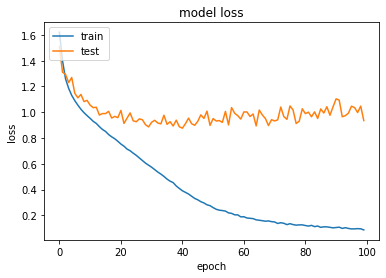

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model and weights
model_name = 'cnn1d_female_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("cnn1d_female_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/cnn1d_female_aug.h5 


In [ ]:
# loading json and model architecture 
json_file = open('cnn1d_female_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/cnn1d_female_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 75.16%


In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

8435/8435 [==============================] - 2s 193us/step


array([0, 0, 0, ..., 4, 2, 1])

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_neutral,female_neutral
171,female_neutral,female_neutral
172,female_disgust,female_disgust
173,female_angry,female_angry
174,female_disgust,female_disgust
175,female_angry,female_angry
176,female_fear,female_fear
177,female_disgust,female_disgust
178,female_angry,female_angry
179,female_surprise,female_surprise


In [ ]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,1292
female_disgust,1138
female_fear,1372
female_happy,1322
female_neutral,1373
female_sad,1348
female_surprise,590


In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_angry' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral' or 'female_disgust':
        return 'female'

0.7516301126259632


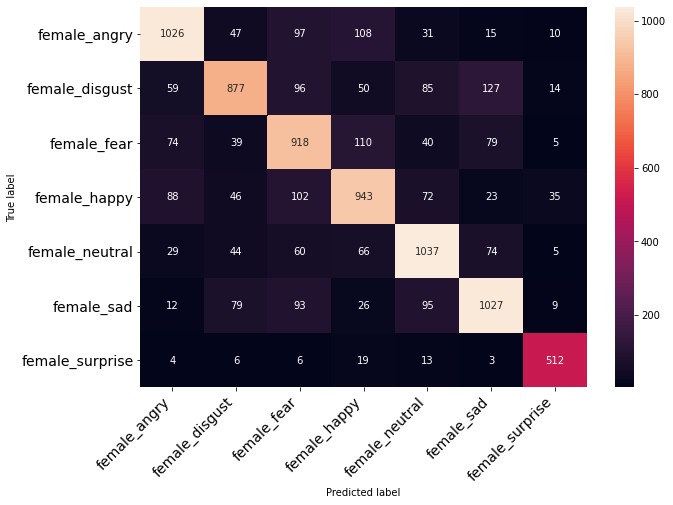

In [ ]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.79      0.77      0.78      1334
 female_disgust       0.77      0.67      0.72      1308
    female_fear       0.67      0.73      0.70      1265
   female_happy       0.71      0.72      0.72      1309
 female_neutral       0.76      0.79      0.77      1315
     female_sad       0.76      0.77      0.76      1341
female_surprise       0.87      0.91      0.89       563

       accuracy                           0.75      8435
      macro avg       0.76      0.76      0.76      8435
   weighted avg       0.75      0.75      0.75      8435

